In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
db=sqlite3.connect("./database.sqlite")

In [3]:
filtered_data=pd.read_sql_query("""Select * from Reviews where Score!=3 limit 5000""",db)

filtered_data.shape

(5000, 10)

In [4]:
def score_partition(x):
    if x<3:
        return "negative"
    return"positive"


actual_score=filtered_data["Score"]
pos_neg=actual_score.map(score_partition)
filtered_data['Score']=pos_neg

In [5]:
filtered_data.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


In [7]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)

In [8]:
final.shape
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,positive,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,positive,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,961718400,Great Product,This was a really good idea and the final prod...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,positive,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
final.shape

(4986, 10)

In [11]:
final['Score'].value_counts()

positive    4178
negative     808
Name: Score, dtype: int64

#  Text preprocessing

#  Cleaning

In [12]:
stopwords_list= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [13]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [14]:
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords_list)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1331.27it/s]


In [15]:
preprocessed_reviews[500]

'good snack feel great offering month old easily pick small pieces definitely enjoys apple cinnamon taste year old loves well would definitely recommend anyone small larger kids'

# Bag of words

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
vect=CountVectorizer()
final_count=vect.fit(preprocessed_reviews)


In [17]:
final_count=vect.transform(preprocessed_reviews)

In [50]:
final_count.shape


(4986, 12997)

# bi-grams

In [19]:
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


# tf-idf

In [20]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


# word2vec

In [21]:
    i=0
    list_of_sentance=[]
    for sentance in preprocessed_reviews:
        list_of_sentance.append(sentance.split())
        
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))

[('satisfying', 0.9925521612167358), ('tasty', 0.992501974105835), ('ok', 0.992483913898468), ('love', 0.9924299716949463), ('excellent', 0.9923924207687378), ('chewy', 0.9923669099807739), ('terrific', 0.9922110438346863), ('either', 0.9921691417694092), ('care', 0.9920085668563843), ('alternative', 0.9919885993003845)]
[('varieties', 0.9995002746582031), ('wow', 0.999380886554718), ('awful', 0.999357283115387), ('lover', 0.9993532299995422), ('peanuts', 0.9993108510971069), ('experience', 0.9992965459823608), ('bars', 0.9992824792861938), ('popcorn', 0.9992818236351013), ('level', 0.9992806315422058), ('normal', 0.999239444732666)]


In [22]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


In [23]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:08<00:00, 602.68it/s]


4986
50


# tf-idf weighted word2vec

In [24]:
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [25]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:58<00:00, 85.80it/s]


# t-sne on bag of word

In [26]:
""""from sklearn.manifold import TSNE
   
final_5000=final_count[0:4000]
final_5000 = final_5000.toarray()
labels = final['Score']
labels_2000 = labels[0:4000]

  
model = TSNE(n_components=2, random_state=0,n_iter=2000,)
tsne_data = model.fit_transform(final_5000)

    # creating a new data frame which help us in ploting the result 
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
      
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", 
      "label"))

    # Ploting the result of tsne

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 
      'Dim_1', 'Dim_2').add_legend()
plt.show()"""


'"from sklearn.manifold import TSNE\n   \nfinal_5000=final_count[0:4000]\nfinal_5000 = final_5000.toarray()\nlabels = final[\'Score\']\nlabels_2000 = labels[0:4000]\n\n  \nmodel = TSNE(n_components=2, random_state=0,n_iter=2000,)\ntsne_data = model.fit_transform(final_5000)\n\n    # creating a new data frame which help us in ploting the result \ntsne_data = np.vstack((tsne_data.T, labels_2000)).T\n      \ntsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", \n      "label"))\n\n    # Ploting the result of tsne\n\nsns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, \n      \'Dim_1\', \'Dim_2\').add_legend()\nplt.show()'

# tsne for word2vec

In [27]:
"""""from sklearn.manifold import TSNE
   
final_5000=sent_vectors[0:400]

labels = final['Score']
labels_2000 = labels[0:400]

  
model = TSNE(n_components=2, random_state=0,n_iter=2000,perplexity=50)
tsne_data = model.fit_transform(final_5000)

    # creating a new data frame which help us in ploting the result 
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
      
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", 
      "label"))

    # Ploting the result of tsne

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 
      'Dim_1', 'Dim_2').add_legend()
plt.show()
""""

SyntaxError: EOL while scanning string literal (<ipython-input-27-4c2cfa296c53>, line 23)

# tsne for tf-idf w2v

In [ ]:
""""from sklearn.manifold import TSNE
   
final_5000=tfidf_sent_vectors[0:400]

labels = final['Score']
labels_2000 = labels[0:400]

  
model = TSNE(n_components=2, random_state=0,n_iter=2000,perplexity=50)
tsne_data = model.fit_transform(final_5000)

    # creating a new data frame which help us in ploting the result 
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
      
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", 
      "label"))

    # Ploting the result of tsne

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 
      'Dim_1', 'Dim_2').add_legend()
plt.show()
""""

Applying KNN brute force

# Applying KNN brute force on BOW

In [28]:
from sklearn.cross_validation import train_test_split,cross_val_score
from sklearn.neighbors import KNeighborsClassifier


C:\Users\D-virus\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [105]:
final_reviews=final['Text'].values
final_score=final['Score']
X=final_reviews
y=final_score

In [106]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

# BoW

misclassification error


In [43]:
from sklearn.feature_extraction.text import CountVectorizer

In [44]:
vectorizer=CountVectorizer()

In [47]:
train_vect=vectorizer.fit_transform(X_train)
test_vect=vectorizer.transform(X_test)

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score

In [122]:
# creating odd k neighbors
neighbors=np.arange(1,50,2)
neighbors

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])

In [123]:
cv_scores=[]


# 3 fold cross validation

In [124]:
for k in neighbors:
    knn=KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores=cross_val_score(knn,train_vect,y_train,scoring='accuracy',cv=3)
    cv_scores.append(scores.mean())

    

In [125]:
optimal_k=neighbors[cv_scores.index(max(cv_scores))]
print("best k:",optimal_k)

best k: 17


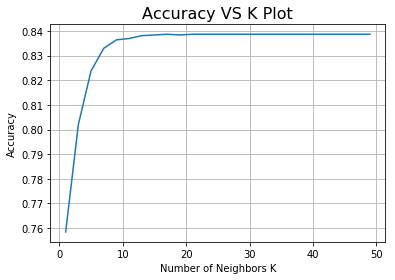

In [126]:
plt.plot(neighbors,cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

In [66]:
print("\n Accuracy for each k value is : ", np.round(cv_scores,3))


 Accuracy for each k value is :  [0.804 0.832 0.836 0.837 0.839 0.838 0.84  0.839 0.839 0.839 0.839 0.839
 0.839 0.839 0.839 0.839 0.839 0.839 0.839 0.839 0.839 0.839 0.839 0.839
 0.839]


# knn with best k=13

In [133]:
knn=KNeighborsClassifier(n_neighbors=13,algorithm='brute')

In [134]:
knn.fit(train_vect,y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=13, p=2,
           weights='uniform')

In [135]:
y_pred=knn.predict(test_vect)
y_train_pred=knn.predict(train_vect)

In [140]:
accuracy_score(y_test,y_pred)*100

83.55614973262033

In [83]:
class_names=['negative','positive']
conf_mat=pd.DataFrame(confusion_matrix(y_test,y_pred),index=class_names)

plt.figure(figsize=(6,4))
sns.heatmap(conf_mat,annot=True,fmt='d')

plt.show()

# 3 Fold Cross-Validation (kd_tree implementation)

In [97]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
X_train_vec_dense = svd.fit_transform(train_vect)
X_test_vec_dense = svd.transform(test_vect)



neighbors_kd = np.arange(1,50,2)

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, X_train_vec_dense, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors_kd[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 19.


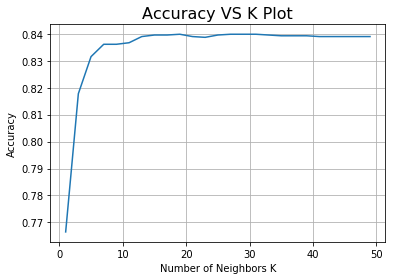


 Accuracy for each k value is :  [0.766 0.818 0.832 0.836 0.836 0.837 0.839 0.84  0.84  0.84  0.839 0.839
 0.84  0.84  0.84  0.84  0.84  0.839 0.839 0.839 0.839 0.839 0.839 0.839
 0.839]


In [98]:
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))


In [101]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree', n_jobs=-1)

# fitting the model
knn_optimal.fit(X_train_vec_dense, y_train)

# predict the response
pred = knn_optimal.predict(X_test_vec_dense)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
bow_kdTree_K = optimal_k
bow_kdTree_train_acc = max(cv_scores)*100
bow_kdTree_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 19 is 83.288770%


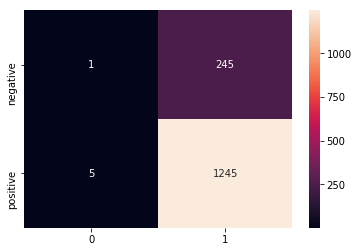

In [102]:
class_names=['negative','positive']
conf_mat=pd.DataFrame(confusion_matrix(y_test,pred),index=class_names)

plt.figure(figsize=(6,4))
sns.heatmap(conf_mat,annot=True,fmt='d')

plt.show()

# Tf-idf

In [107]:
tf_idf=TfidfVectorizer(min_df=10)
tf_idf_vect_train=tf_idf_vect.fit_transform(X_train)
tf_idf_vect_test=tf_idf_vect.transform(X_test)




# 3 Fold Cross-Validation (kd_tree implementation)

In [129]:
# creating odd list of K for KNN
neighbors_tf=np.arange(1,30,2)

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors_tf:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, tf_idf_vect_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors_tf[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 7.


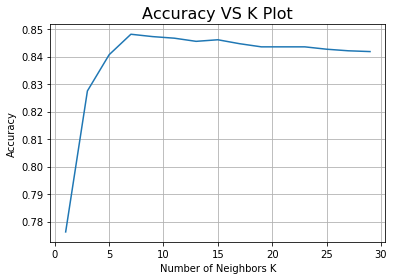


 Accuracy for each k value is :  [0.776 0.828 0.841 0.848 0.847 0.847 0.846 0.846 0.845 0.844 0.844 0.844
 0.843 0.842 0.842]


In [130]:
plt.plot(neighbors_tf, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))


# Applying Multinomial Naive Bayes

In [141]:
from sklearn.naive_bayes import MultinomialNB

In [148]:
naive_model=MultinomialNB()
naive_model.fit(train_vect,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [151]:
test_pred=naive_model.predict(test_vect)

In [153]:
accuracy_score(y_test,test_pred)*100

83.15508021390374

# 10 fold cv

In [319]:
neighbors_naive=[]
i = 0.001
while(i<=1000):
    neighbors_naive.append(np.round(i,3))
    i *= 3
cv_scores=[]

In [320]:
for k in neighbors_naive:
    naive_model=MultinomialNB(alpha=k)
    scores=cross_val_score(naive_model,train_vect,y_train,scoring='accuracy',cv=10)
    cv_scores.append(scores.mean())
    

    

In [321]:
# determining best alpha
optimal_alpha = neighbors_naive[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of alpha is %d.' % optimal_alpha)


The optimal number of alpha is 531.


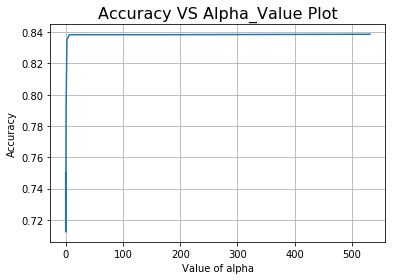

In [326]:
plt.plot(neighbors_naive, cv_scores)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha_Value Plot',size=16)
plt.grid()
plt.show()



In [328]:
# ============================== Multinomial Naive Bayes with alpha = optimal_alpha ============================================
# instantiate learning model alpha = optimal_alpha
bn_optimal = MultinomialNB(alpha = optimal_alpha)

# fitting the model
bn_optimal.fit(train_vect, y_train)

# predict the response
predictions = bn_optimal.predict(test_vect)

# evaluate accuracy
acc = accuracy_score(y_test, predictions) * 100
print('\nThe Test Accuracy of the Multinomial naive Bayes classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
bow_multinomial_alpha = optimal_alpha
bow_multinomial_train_acc = max(cv_scores)*100
bow_multinomial_test_acc = acc


The Test Accuracy of the Multinomial naive Bayes classifier for alpha = 531.441 is 83.622995%


In [329]:
bn_optimal.classes_

array(['negative', 'positive'], dtype='<U8')

In [330]:
# Now we can find log probabilities of different features for both the classes
class_features = bn_optimal.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_features = class_features[0]
positive_features = class_features[1]

# Getting all feature names
feature_names = count_vect.get_feature_names()

# Sorting 'negative_features' and 'positive_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]
sorted_positive_features = np.argsort(positive_features)[::-1]

print("Top 20 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))

Top 20 Important Features and their log probabilities For Negative Class :




IndexError: list index out of range